In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.signal as sg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import os
import time
import scipy.interpolate as interpolate


Bad key "text.kerning_factor" on line 4 in
C:\Users\Marcus\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data_path = '../Data/mat/'

In [3]:
fnames = [f for f in os.listdir(data_path) if '.mat' in f]
print(fnames)

['201118_cell1_A.mat', '201119_cell2_A.mat', '201119_cell7_A.mat', '201121_cell1_A.mat']


In [4]:
cell_name = '201121_cell1_A'

In [5]:
fname = data_path + cell_name + '.mat'
dat = h5py.File(fname, 'r')['ExpStruct']
print(dat.keys())

<KeysViewHDF5 ['OnePpulse', 'OnePpulse_inputs', 'Rm', 'Rs', 'SISocket', 'cell_paramneters_execution_times', 'cellcheck_ephys_inputs', 'daqParams', 'expParams', 'holoRequest', 'holoSocket', 'holoStimParams', 'inputs', 'mouseID', 'multiclamp_Rs_log', 'notes', 'outParams', 'testpulse', 'trialCond']>


# Plot sample

In [6]:
window_len = 30000 # sample 30k timepoints
dat_sample = np.array(dat[dat['inputs'][0, 1]])[0, :window_len]

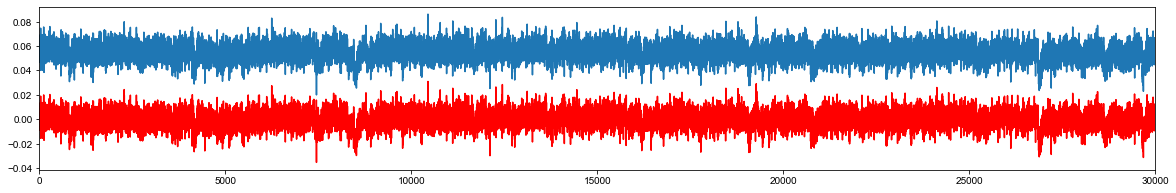

In [7]:
plt.figure(figsize=(20, 3))
plt.plot(dat_sample)
plt.plot(sg.detrend(dat_sample), color='r')
plt.xlim([0, window_len])
plt.show()

In [8]:
srate = (np.array(dat['daqParams']['Fs'])).item()
lpcut = 2000
blp, alp = sg.butter(4, lpcut, btype='low', fs=srate) # butterworth filter
dat_samp_filtered = sg.filtfilt(blp, alp, dat_sample)

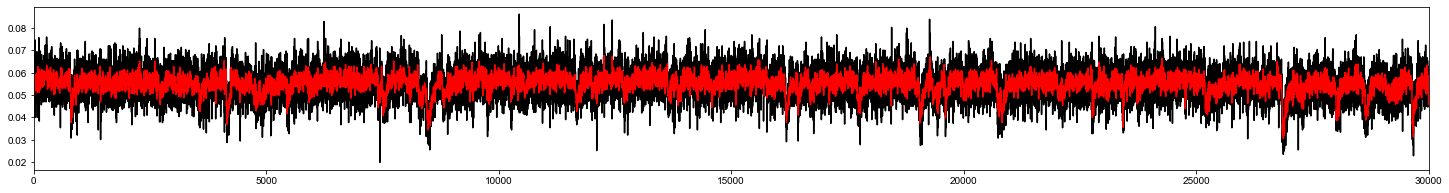

In [9]:
plt.figure(figsize=(25, 3))
plt.plot(dat_sample, color='k')
plt.plot(dat_samp_filtered, color='r')
plt.xlim([0, window_len])
plt.show()

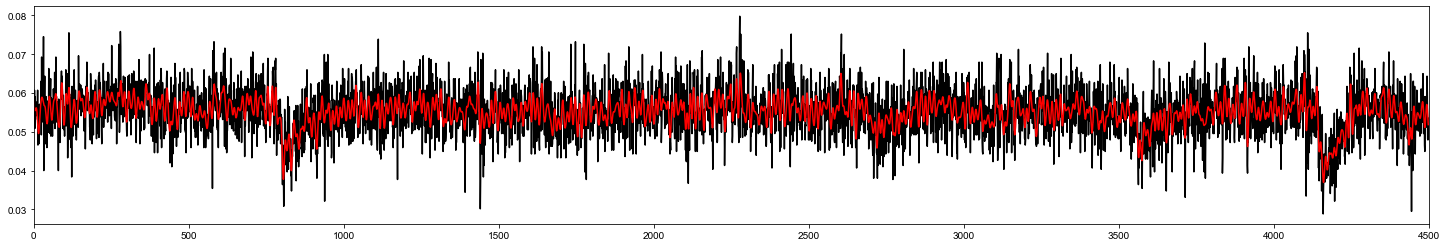

In [10]:
# Close-up view
plt.figure(figsize=(25, 4))
plt.plot(dat_sample[:4500], color='k')
plt.plot(dat_samp_filtered[:4500], color='r')
plt.xlim([0, 4500])
plt.show()

In [11]:
nextHoloStims = np.array(dat[dat['outParams']['nextHoloStims'][0][0]]).squeeze()
nextHoloStims_sample = nextHoloStims[:window_len]

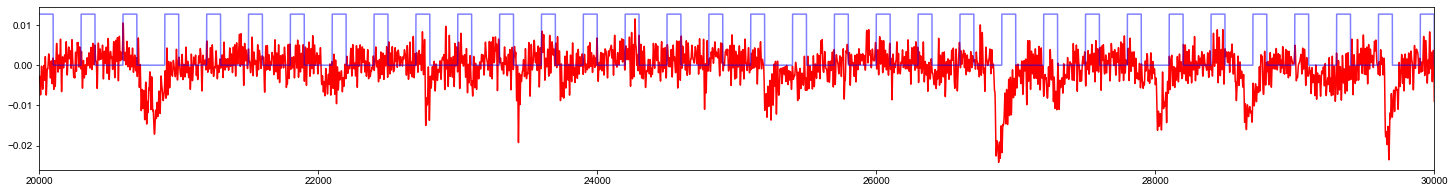

In [12]:
sdat = dat_samp_filtered - np.mean(dat_samp_filtered)
plt.figure(figsize=(25, 3))
plt.plot(sdat, color='r')
plt.plot(nextHoloStims_sample*np.max(sdat), color='blue', alpha=0.5) # laser on
plt.xlim([2e4, 3e4])
# plt.xlim([0, window_len])
plt.show()

# Separate into trials, from start of opto stim to start of next opto stim

In [13]:
# Set up parameters
srate = (np.array(dat['daqParams']['Fs'])).item()
trial_len = int(15/1000 * srate) # 15ms trial length
ms = 1e-3 * srate
n_frames_stim_on = 100
recording_len = 1080000
lpcut = 2000

In [14]:
# butterworth filter
blp, alp = sg.butter(4, lpcut, btype='low', fs=srate)

# stim onset times
nextHoloStims = np.array(dat[dat['outParams']['nextHoloStims'][0][0]]).squeeze()
holo_start = np.where(nextHoloStims)[0][0]
holo_end = np.where(nextHoloStims)[0][-1] - n_frames_stim_on + 1

# xyz target locations
targets = dat['holoRequest']['actualtargets'][:].T
nstim = targets.shape[0]

# calc number of trials (avoiding null trials)
ntrials = 0
for j in range(dat['inputs'][0].shape[0]):
    if np.array(dat[dat['inputs'][0, j]]).squeeze().shape[0] == recording_len:
        ntrials += 1

stim_orders = np.array([dat[dat['outParams']['sequenceThisTrial'][:, 0][i]][:, 0].astype(int) for i in range(ntrials)]) - 1
currf = np.zeros((ntrials, nstim, trial_len))
sorted_stim_orders = np.argsort(stim_orders, 1)

In [15]:
two_d_locs = targets[targets[:, 2] == 0, :2]

In [16]:
def get_currf(i):
    # gets lp-filtered postsynaptic current trace on trial i
    curr = np.array(dat[dat['inputs'][0, i]]).squeeze()
    _filtered_curr = sg.detrend(sg.filtfilt(blp, alp, curr), type='linear')
    
    _currf = np.array([_filtered_curr[t:t + trial_len] for t in range(holo_start, holo_end + 1, trial_len)])
    return _currf

In [17]:
print(dat.keys())

<KeysViewHDF5 ['OnePpulse', 'OnePpulse_inputs', 'Rm', 'Rs', 'SISocket', 'cell_paramneters_execution_times', 'cellcheck_ephys_inputs', 'daqParams', 'expParams', 'holoRequest', 'holoSocket', 'holoStimParams', 'inputs', 'mouseID', 'multiclamp_Rs_log', 'notes', 'outParams', 'testpulse', 'trialCond']>


In [18]:
# power level conditions
trialCond = dat['trialCond'][:, 0]
print(trialCond)

[2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 1.]


In [19]:
# find locations of low vs high powers
cond_locs = [np.where(trialCond == i)[0] for i in range(1, 3)]
print(cond_locs)

[array([ 1,  2,  3,  4,  5,  6,  7,  8, 12, 13, 19, 23], dtype=int64), array([ 0,  9, 10, 11, 14, 15, 16, 17, 18, 20, 21, 22], dtype=int64)]


In [20]:
# second low-power condition is
print(cond_locs[0][2])

3


In [21]:
currf_low_power = np.array([get_currf(trial)[sorted_stim_orders[trial]] for trial in cond_locs[0]])
print(currf_low_power.shape) # 5 trials x 3380 stimuli x 300 timepoints (15ms)

(12, 3380, 300)


In [22]:
currf_high_power = np.array([get_currf(trial)[sorted_stim_orders[trial]] for trial in cond_locs[1]])
# currf_high_power = np.array([get_currf(trial)[stim_orders[i]] for i, trial in enumerate(cond_locs[1])]) # random order
print(currf_high_power.shape)

(12, 3380, 300)


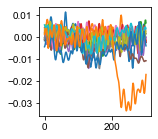

In [23]:
plt.figure(figsize=(2, 2))
plt.plot(currf_high_power[:, 423, :].T)
plt.show()

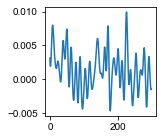

In [24]:
plt.figure(figsize=(2, 2))
plt.plot(currf_high_power[1, 423, :].T)
plt.show()

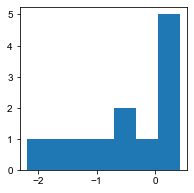

In [25]:
plt.figure(figsize=(3, 3))
plt.hist(np.trapz(currf_high_power[:, 423, :], axis=1), 7)
plt.show()

## Raw postsynaptic responses across 3380 stim locations

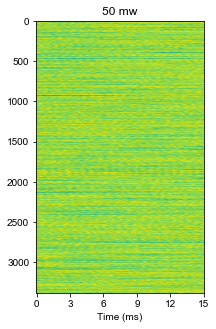

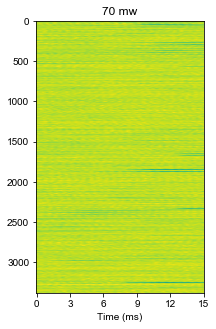

In [26]:
plt.figure(figsize=(3, 5))
plt.title('50 mw')
plt.imshow(np.mean(currf_low_power, 0), aspect='auto')
plt.xticks(np.arange(0, trial_len + 1, 60))
plt.gca().set_xticklabels(np.arange(0, 16, 3))
plt.xlabel('Time (ms)')
plt.show()

plt.figure(figsize=(3, 5))
plt.title('70 mw')
plt.imshow(np.mean(currf_high_power, 0), aspect='auto')
plt.xticks(np.arange(0, trial_len + 1, 60))
plt.gca().set_xticklabels(np.arange(0, 16, 3))
plt.xlabel('Time (ms)')
plt.show()

## Sorted postsynaptic responses across 3380 stim locations

In [27]:
currf_low_power_avg = np.mean(currf_low_power, 0)
order_low_power = np.argsort(np.mean(currf_low_power_avg, 1))[::-1]

currf_high_power_avg = np.mean(currf_high_power, 0)
order_high_power = np.argsort(np.mean(currf_high_power_avg, 1))[::-1]

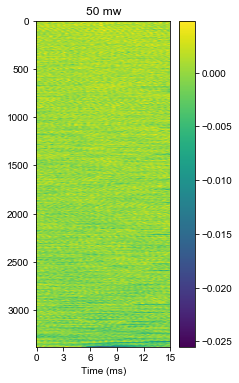

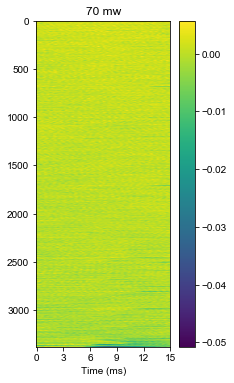

In [28]:
plt.figure(figsize=(3, 6))
plt.imshow(currf_low_power_avg[order_low_power], aspect='auto')
plt.colorbar()
plt.xticks(np.arange(0, trial_len + 1, 60))
plt.gca().set_xticklabels(np.arange(0, 16, 3))
plt.xlabel('Time (ms)')
plt.title('50 mw')
plt.show()

plt.figure(figsize=(3, 6))
plt.imshow(currf_high_power_avg[order_high_power], aspect='auto')
plt.colorbar()
plt.xticks(np.arange(0, trial_len + 1, 60))
plt.gca().set_xticklabels(np.arange(0, 16, 3))
plt.xlabel('Time (ms)')
plt.title('70 mw')
plt.show()

## Low-power responses, sorted by stim location

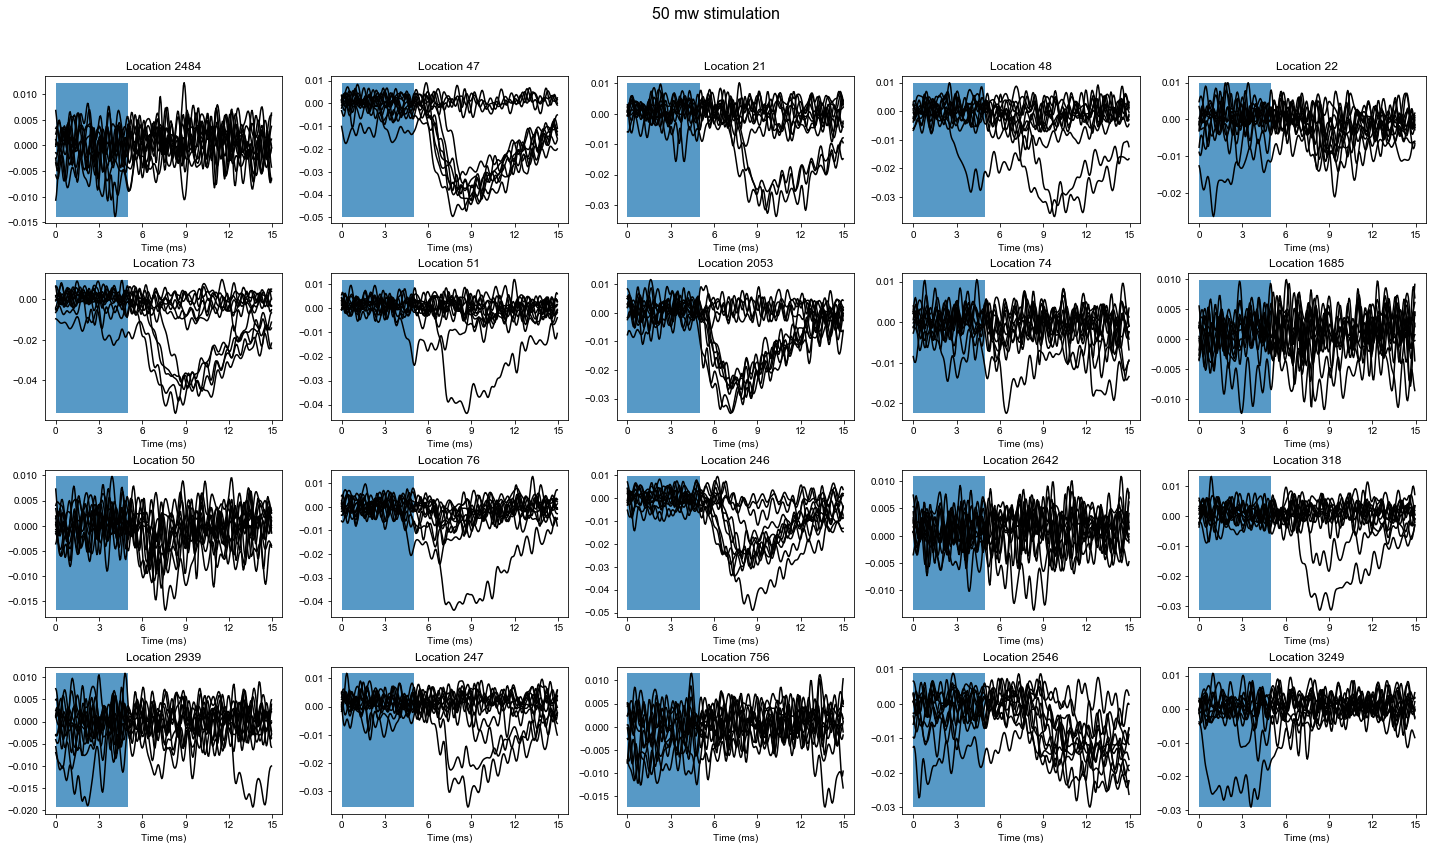

In [29]:
plt.figure(figsize=(20, 12))
for j in range(1, 21):
    plt.subplot(4, 5, j)
    i = order_high_power[-j]
    plt.plot(currf_low_power[:, i, :].T, color='k')
    min_ = np.min(currf_low_power[:, i, :])
    max_ = np.max(currf_low_power[:, i, :])
    plt.fill_between([0, 5 * ms], [max_, max_], [min_, min_], alpha=0.75)
    plt.xticks(np.arange(0, trial_len + 1, 60))
    plt.gca().set_xticklabels(np.arange(0, 16, 3))
    plt.xlabel('Time (ms)')
    plt.title('Location %i'%i)
plt.suptitle('50 mw stimulation', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

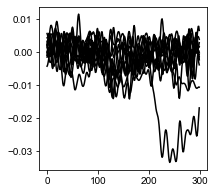

In [30]:
plt.figure(figsize=(3, 3))
plt.plot(currf_high_power[:, 423, :].T, color='k')
plt.show()

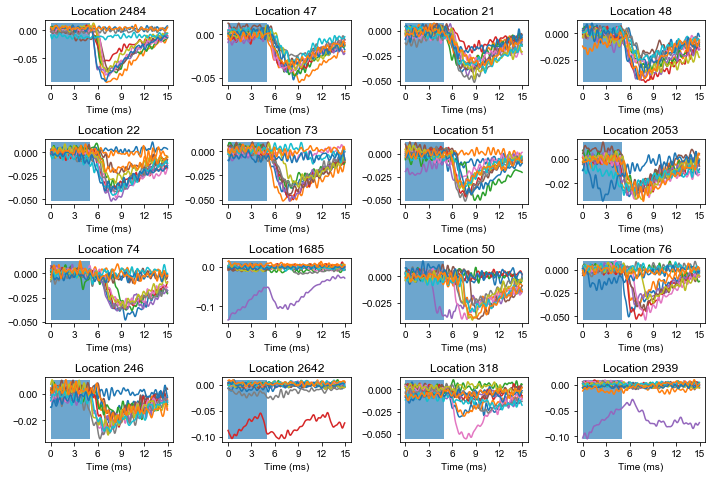

In [31]:
nfigs = 17
plt.figure(figsize=(10, 8))
for j in range(1, nfigs):
    plt.subplot(int(np.ceil(nfigs/4)), 4, j)
    i = order_high_power[-j]
#     plt.plot(currf_low_power[:, i, :].T, color='firebrick')
    plt.plot(currf_high_power[:, i, :].T)
    min_ = np.min(currf_high_power[:, i, :])
    max_ = np.max(currf_high_power[:, i, :])
    plt.fill_between([0, 5 * ms], [max_, max_], [min_, min_], alpha=0.65)
    plt.xticks(np.arange(0, trial_len + 1, 60))
    plt.gca().set_xticklabels(np.arange(0, 16, 3))
    plt.xlabel('Time (ms)')
    plt.title('Location %i'%i)
# plt.suptitle('70 mw stimulation', fontsize=16)
plt.tight_layout()
# plt.subplots_adjust(top=0.90)
# plt.savefig('figs/example_blind_mapping_psc_multi_col_high_power.pdf', format='pdf', bbox_inches='tight')
plt.show()

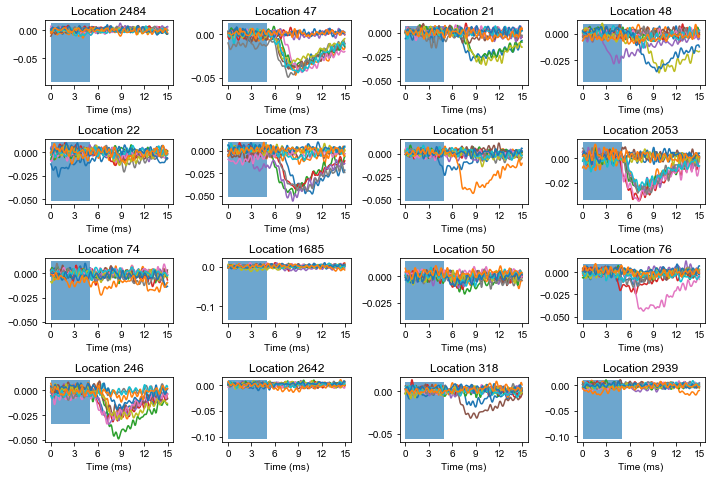

In [32]:
nfigs = 17
plt.figure(figsize=(10, 8))
for j in range(1, nfigs):
    plt.subplot(int(np.ceil(nfigs/4)), 4, j)
    i = order_high_power[-j]
    plt.plot(currf_low_power[:, i, :].T)
#     plt.plot(currf_high_power[:, i, :].T)
    min_ = np.min(currf_high_power[:, i, :])
    max_ = np.max(currf_high_power[:, i, :])
    plt.fill_between([0, 5 * ms], [max_, max_], [min_, min_], alpha=0.65)
    plt.xticks(np.arange(0, trial_len + 1, 60))
    plt.gca().set_xticklabels(np.arange(0, 16, 3))
    plt.xlabel('Time (ms)')
    plt.title('Location %i'%i)
# plt.suptitle('70 mw stimulation', fontsize=16)
plt.tight_layout()
# plt.subplots_adjust(top=0.90)
# plt.savefig('figs/example_blind_mapping_psc_multi_col_low_power.pdf', format='pdf', bbox_inches='tight')
plt.show()

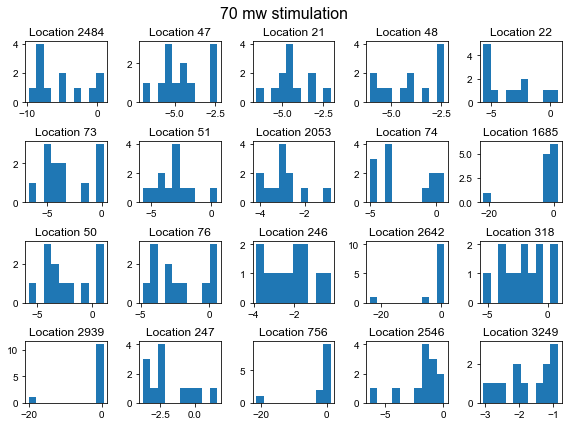

In [33]:
plt.figure(figsize=(8, 6))
for j in range(1, 21):
    plt.subplot(4, 5, j)
    i = order_high_power[-j]
    plt.hist(np.trapz(currf_high_power[:, i, :], axis=1))
    plt.title('Location %i'%i)
plt.suptitle('70 mw stimulation', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [34]:
y = np.array([np.trapz(currf_high_power[:, i, :], axis=1) for i in range(currf_high_power.shape[1])]).flatten()

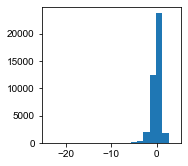

In [35]:
plt.figure(figsize=(2.5, 2.5))
plt.hist(y, 20)
plt.show()

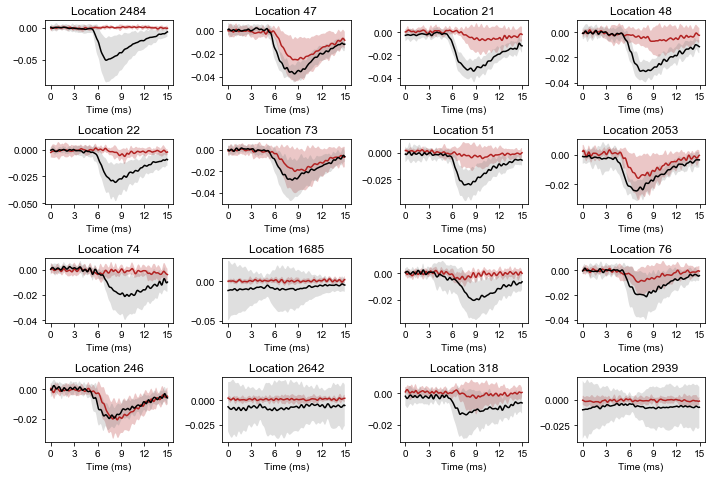

In [36]:
nfigs = 17
plt.figure(figsize=(10, 8))
for j in range(1, nfigs):
    plt.subplot(int(np.ceil(nfigs/4)), 4, j)
    i = order_high_power[-j]
    lpmean = np.mean(currf_low_power[:, i, :], 0)
    lp_sdev = np.std(currf_low_power[:, i, :], 0)
    plt.plot(lpmean, color='firebrick')
    plt.fill_between(np.arange(trial_len), lpmean - lp_sdev, lpmean + lp_sdev, facecolor='firebrick', edgecolor='None', alpha=0.25)
    
    hpmean = np.mean(currf_high_power[:, i, :], 0)
    hp_sdev = np.std(currf_high_power[:, i, :], 0)
    plt.plot(hpmean, color='k')
    plt.fill_between(np.arange(trial_len), hpmean - hp_sdev, hpmean + hp_sdev, facecolor='gray', edgecolor='None', alpha=0.25)
#     min_ = np.min(currf_high_power[:, i, :])
#     max_ = np.max(currf_high_power[:, i, :])
#     plt.fill_between([0, 5 * ms], [max_, max_], [min_, min_], alpha=0.75)
    plt.xticks(np.arange(0, trial_len + 1, 60))
    plt.gca().set_xticklabels(np.arange(0, 16, 3))
    plt.xlabel('Time (ms)')
    plt.title('Location %i'%i)
# plt.suptitle('70 mw stimulation', fontsize=16)
plt.tight_layout()
# plt.subplots_adjust(top=0.90)
# plt.savefig('figs/example_blind_mapping_psc_low_vs_high_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Excitatory maps

### -25 $\mu$m example

In [37]:
targets_inds_plane_0 = np.where(targets[:, -1] == 0)[0]
targets_plane_0 = targets[targets_inds_plane_0]

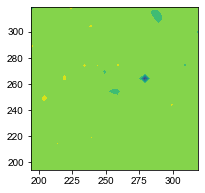

In [38]:
# Contour
plt.figure(figsize=(3, 3))
plt.contourf(targets_plane_0[:, 0].reshape([26, 26]), targets_plane_0[:, 1].reshape([26, 26]), np.min(currf_high_power_avg[targets_inds_plane_0], 1).reshape([26, 26]))
plt.show()

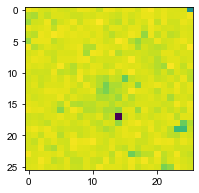

In [39]:
# Raw
plt.figure(figsize=(3, 3))
plt.imshow(np.reshape(np.min(currf_high_power_avg[targets_inds_plane_0], 1), [26, 26]), aspect='auto')
plt.show()

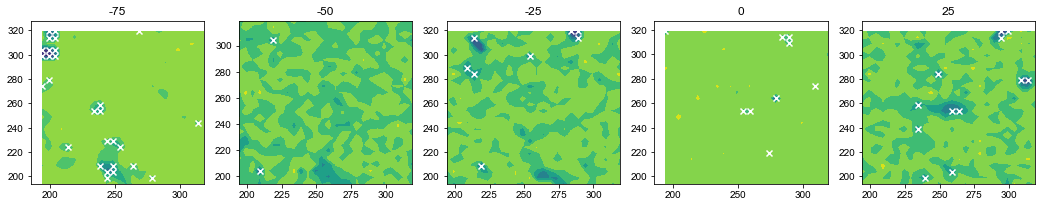

In [40]:
plt.figure(figsize=(18, 3))
for indx, loc in enumerate([-75, -50, -25, 0, 25]):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
#     plt.figure(figsize=(3, 3))
    plt.subplot(1, 5, indx + 1)
    plt.title(loc)
    plt.contourf(tars[:, 0].reshape([26, 26]), tars[:, 1].reshape([26, 26]), np.min(currf_high_power_avg[tar_plane], 1).reshape([26, 26]))
    for j in range(1, 60):
        i = order_high_power[-j]
        if targets[i][-1] == loc:
            plt.scatter(targets[i][0], targets[i][1], marker='x', color='white')
plt.show()

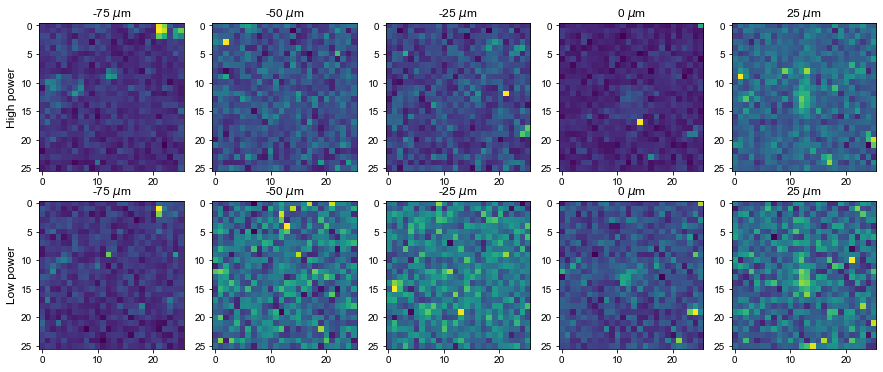

In [41]:
plt.figure(figsize=(15, 6))
depths = [-75, -50, -25, 0, 25]
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(2, 5, indx + 1)
    plt.title(str(loc) + ' $\mu$m')
    plt.imshow(np.reshape(np.trapz(currf_high_power_avg[tar_plane], axis=1), [26, 26]), aspect='auto', cmap='viridis_r')
    if indx == 0:
        plt.ylabel('High power', fontsize=12)
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(2, 5, indx + 1 + len(depths))
    plt.title(str(loc) + ' $\mu$m')
    plt.imshow(np.reshape(np.trapz(currf_low_power_avg[tar_plane], axis=1), [26, 26]), aspect='auto', cmap='viridis_r')
    if indx == 0:
        plt.ylabel('Low power', fontsize=12)
# plt.savefig('figs/example_blind_maps_5_plane_high_vs_low_power.pdf', format='pdf', bbox_inches='tight')    
plt.show()

In [42]:
from scipy.ndimage.measurements import label
from scipy.ndimage.morphology import generate_binary_structure
# s = generate_binary_structure(2,2)

def get_cell_coms(fov, binary_thresh=-0.07):
    fov_lab, num_features = label(fov < binary_thresh)
    coms = [None] * num_features
    for i in range(num_features):
        xlocs, ylocs = np.where(fov_lab == (i + 1))
        coms[i] = int(np.round(np.mean(xlocs))), int(np.round(np.mean(ylocs)))
    return coms

In [43]:
binary_thresh = -0.07

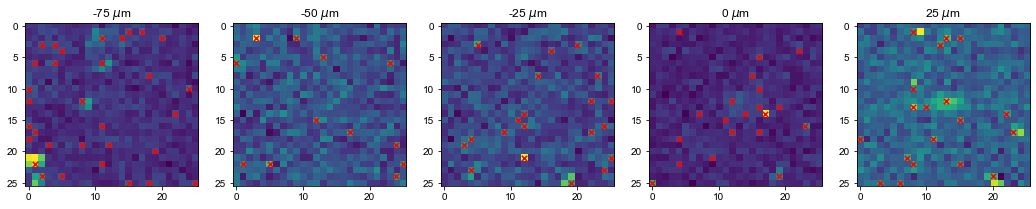

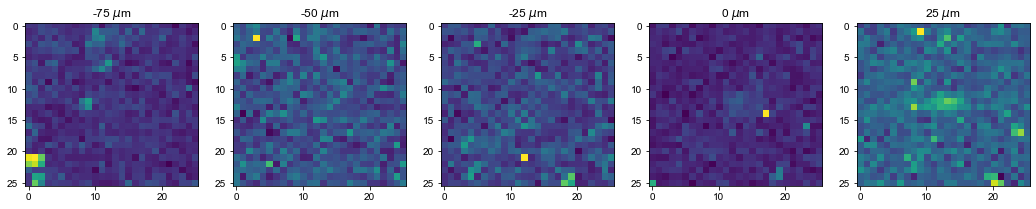

In [44]:
depths = [-75, -50, -25, 0, 25]
thresh = np.percentile(np.trapz(currf_high_power_avg, axis=1), 5)

plt.figure(figsize=(18, 3))
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(1, 5, indx + 1)
    plt.title(str(loc) + ' $\mu$m')
    fov = np.trapz(currf_high_power_avg[tar_plane], axis=1).reshape([26, 26])
    plt.imshow(fov.T, cmap='viridis_r', aspect='auto')
    coms = get_cell_coms(fov, thresh)
    for com in coms:
        plt.scatter(com[0], com[1], 30, marker='x', facecolor='r')
# plt.savefig('figs/tentative_cell_locs.pdf', bbox_inches='tight', format='pdf')
plt.show()

plt.figure(figsize=(18, 3))
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(1, 5, indx + 1)
    plt.title(str(loc) + ' $\mu$m')
    fov = np.trapz(currf_high_power_avg[tar_plane], axis=1).reshape([26, 26])
    plt.imshow(fov.T, cmap='viridis_r', aspect='auto')
plt.show()

In [45]:
# find corresponding coordinates

In [46]:
num_2d_locs = len(np.where(targets == 0)[0])

In [47]:
reference_list = np.arange(num_2d_locs)
reference_array = reference_list.reshape([26, 26])

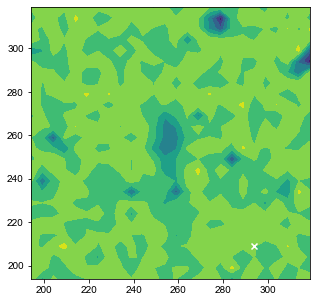

In [48]:
plt.figure(figsize=(5, 5))
plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), np.min(currf_high_power_avg[tar_plane], 1).reshape(26, 26))
plt.scatter([294], [209], marker='x', color='white')
plt.show()

# Save data in a format for adaprobe

In [49]:
cell_locs = np.empty((0, 3))
for loc in depths:
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    fov = np.trapz(currf_high_power_avg[tar_plane], axis=1).reshape([26, 26])
    coms = two_d_locs[np.array([reference_array[c] for c in get_cell_coms(fov, thresh)])]
    cell_locs = np.r_[cell_locs, np.c_[coms, loc*np.ones(len(coms))]]

In [50]:
low_power = 50
high_power = 70

In [51]:
x = np.empty((0, 4))
x_enum = np.empty((0))
# low power trials
for trial in cond_locs[0]:
    x = np.r_[x, np.c_[targets, low_power * np.ones(nstim)]]
    x_enum = np.r_[x_enum, np.arange(nstim)]
    
# high power trials
for trial in cond_locs[1]:
    x = np.r_[x, np.c_[targets, high_power * np.ones(nstim)]]
    x_enum = np.r_[x_enum, np.arange(nstim)]

In [52]:
n_low_power = 5
n_high_power = 10

In [53]:
y = np.empty((0, trial_len))
# low power trials
for i in range(currf_low_power.shape[0]):
    y = np.r_[y, currf_low_power[i]]

# high power trials
for i in range(currf_high_power.shape[0]):
    y = np.r_[y, currf_high_power[i]]

In [54]:
data = {
    'cell_locs': cell_locs,
    'targets': targets,
    'stim_order': x_enum,
    'stimuli': x,
    'responses': y
}

In [55]:
# np.save('../Data/npy/' + cell_name + '.npy', data)

## Lasso baseline

In [56]:
total_stim = len(y)

In [57]:
from scipy.sparse import csc_matrix

In [58]:
ntrials_to_include = n_low_power + n_high_power
row = np.array(range(nstim * ntrials_to_include))
col = np.array(list(range(nstim)) * ntrials_to_include)
sp_data = np.ones(len(col))

A = csc_matrix((sp_data, (row, col)))

In [59]:
A.shape

(50700, 3380)

In [60]:
y.shape

(81120, 300)

## Ordinary least squares

In [61]:
from scipy.sparse.linalg import lsqr

In [62]:
y_integrated = np.trapz(y, axis=1)
b = lsqr(A, y_integrated)[0]

ValueError: dimension mismatch

In [ ]:
plt.figure(figsize=(18, 3))
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(1, 5, indx + 1)
    plt.title(str(loc) + ' $\mu$m')
#     fov = np.trapz(currf_high_power_avg[tar_plane], axis=1).reshape([26, 26])
    plt.imshow(b[tar_plane].reshape([26, 26]), cmap='viridis_r', aspect='auto')
plt.show()

## lasso

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
alpha = 1e-4
sparse_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
sparse_lasso.fit(A, y_integrated)

In [ ]:
b_sp = sparse_lasso.coef_

In [ ]:
plt.figure(figsize=(18, 3))
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(1, 5, indx + 1)
    plt.title(str(loc) + ' $\mu$m')
    plt.imshow(b_sp[tar_plane].reshape([26, 26]), cmap='viridis_r', aspect='auto')
# np.savefig('')
plt.show()

In [ ]:
plt.figure(figsize=(18, 7))
subplot_cntr = 1
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(2, 5, subplot_cntr)
    plt.title(str(loc) + ' $\mu$m')
    plt.imshow(b[tar_plane].reshape([26, 26]), cmap='viridis_r', aspect='auto')
    if indx == 0:
        plt.ylabel('Least squares', fontsize=12)
    subplot_cntr += 1
    
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(2, 5, subplot_cntr)
    plt.imshow(b_sp[tar_plane].reshape([26, 26]), cmap='viridis_r', aspect='auto')
    subplot_cntr += 1
    if indx == 0:
        plt.ylabel('LASSO', fontsize=12)
# plt.savefig('figs/blind_maps_lsq_vs_lasso.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Lasso CV

In [ ]:
from sklearn.linear_model import LassoCV

In [ ]:
%time reg = LassoCV(cv=5, random_state=0, alphas=[1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2]).fit(A, y_integrated)

In [ ]:
reg.coef_

In [ ]:
plt.figure(figsize=(20, 12))
subplot_cntr = 1
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(3, 5, subplot_cntr)
    plt.title(str(loc) + ' $\mu$m')
    plt.imshow(b[tar_plane].reshape([26, 26]), cmap='viridis_r', aspect='auto')
    if indx == 0:
        plt.ylabel('Least squares', fontsize=12)
    subplot_cntr += 1
    
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(3, 5, subplot_cntr)
    plt.imshow(b_sp[tar_plane].reshape([26, 26]), cmap='viridis_r', aspect='auto')
    subplot_cntr += 1
    if indx == 0:
        plt.ylabel('LASSO', fontsize=12)
        
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(3, 5, subplot_cntr)
    plt.imshow(reg.coef_[tar_plane].reshape([26, 26]), cmap='viridis_r', aspect='auto')
    subplot_cntr += 1
    if indx == 0:
        plt.ylabel('LASSO-cv', fontsize=12)
        
# plt.savefig('figs/blind_maps_lsq_vs_lasso.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
reg.get_params(deep=True)

In [ ]:
reg.path

## Separate LASSOcv for low and high power

In [ ]:
cv = 10

#### Low power

In [ ]:
row_lp = np.array(range(nstim * n_low_power))
col_lp = np.array(list(range(nstim)) * n_low_power)
sp_data_lp = np.ones(len(col_lp))

A_lp = csc_matrix((sp_data_lp, (row_lp, col_lp)))

y_lp = y_integrated[:n_low_power*nstim]

In [ ]:
%time reg_lp = LassoCV(cv=10, random_state=0, alphas=[1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2]).fit(A_lp, y_lp)

In [ ]:
subplot_cntr = 1
plt.figure(figsize=(18, 3))
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(1, 5, subplot_cntr)
    plt.imshow(reg_lp.coef_[tar_plane].reshape([26, 26]), cmap='viridis_r', aspect='auto')
    subplot_cntr += 1
    if indx == 0:
        plt.ylabel('LASSO-cv', fontsize=12)
plt.show()

#### High power

In [ ]:
row_hp = np.array(range(nstim * n_high_power))
col_hp = np.array(list(range(nstim)) * n_high_power)
sp_data_hp = np.ones(len(col_hp))

A_hp = csc_matrix((sp_data_hp, (row_hp, col_hp)))
y_hp = y_integrated[n_low_power*nstim:]

In [ ]:
%time reg_hp = LassoCV(cv=cv, random_state=0, alphas=[1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2]).fit(A_hp, y_hp)

In [ ]:
subplot_cntr = 1
plt.figure(figsize=(18, 3))
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(1, 5, subplot_cntr)
    plt.imshow(reg_hp.coef_[tar_plane].reshape([26, 26]), cmap='viridis_r', aspect='auto')
    subplot_cntr += 1
    if indx == 0:
        plt.ylabel('LASSO-cv', fontsize=12)
plt.show()

In [ ]:
subplot_cntr = 1
plt.figure(figsize=(18, 7))
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(2, 5, subplot_cntr)
    plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), reg_lp.coef_[tar_plane].reshape([26, 26]).T, 50, cmap='viridis_r', vmin=-5.4, vmax=0.4)
#     plt.colorbar()
    subplot_cntr += 1
    if indx == 0:
        plt.ylabel('50 mW', fontsize=12)

for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(2, 5, subplot_cntr)
    plt.contourf(np.unique(two_d_locs[:, 0]), np.unique(two_d_locs[:, 1]), reg_hp.coef_[tar_plane].reshape([26, 26]).T, 150, cmap='viridis_r', vmin=-5.4, vmax=0.4)
#     plt.colorbar()
    subplot_cntr += 1
    if indx == 0:
        plt.ylabel('70 mW', fontsize=12)
plt.show()

In [ ]:
subplot_cntr = 1
plt.figure(figsize=(18, 7))
for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(2, 5, subplot_cntr)
    plt.title(str(loc) + ' $\mu$m')
    plt.imshow(reg_lp.coef_[tar_plane].reshape([26, 26]), aspect='auto', cmap='viridis_r', vmin=-5.4, vmax=0.4)
#     plt.colorbar()
    subplot_cntr += 1
    if indx == 0:
        plt.ylabel('50 mW', fontsize=12)

for indx, loc in enumerate(depths):
    tar_plane = np.where(targets[:, -1] == loc)[0]
    tars = targets[tar_plane]
    plt.subplot(2, 5, subplot_cntr)
    plt.imshow(reg_hp.coef_[tar_plane].reshape([26, 26]), aspect='auto', cmap='viridis_r', vmin=-5.4, vmax=0.4)
#     plt.colorbar()
    subplot_cntr += 1
    if indx == 0:
        plt.ylabel('70 mW', fontsize=12)
# plt.savefig('figs/experimental_data/blind_maps.pdf', format='pdf', bbox_inches='tight')
plt.show()